# DarkELF multiphonon notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime.

written by Ethan, updated 02/08/2021

In [1]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

When loading the materials, the "dos_filename" flag must be set in order to calculate rates in the multiphonon regime. The "target_yaml" flag is set automatically and can be overridden. Auxiliary functions "Fn" are pre-tabulated corresponding to the given density of states files and loaded in by default. If using another density of states, one must first run the "create_Fn_omega()" function on the desired density of states.

In [2]:
targets.files('Si')


Available configuration files: 
	 Si.yaml
 
Available data for epsilon: 
	 Si_Migdal_FAC.dat
	 Si_atomic_Z_eps_form_factor.dat
	 Si_mermin.dat
	 Si_gpaw_noLFE.dat
	 Si_gpaw_withLFE.dat
	 Si_epsphonon_theory6K.dat
	 Si_epsphonon_data6K.dat
	 Si_Zion.dat
 
Available data for phonon density of states: 
	 Si_DoS.dat
 
Available data for Fn(omega) functions: 
	 Si_Fn.dat
 
Available data for form factors: 
	 Si_atomic_Z_eps_form_factor.dat


If one is only interested in the multiphonon response, the electronic response specified with the "filename" flag is not used. If it is not specified, the code will produce a warning message, as seen below. There's also an optional form_factor_filename if one is interested in using a custom DM-atomic form factor. These can be ignored as long as we only care about DM-multiphonon scattering. Let's load a few materials.

In [2]:
gaas = darkelf(target='GaAs',dos_filename="GaAs_DoS.dat")
si = darkelf(target='Si',dos_filename="Si_DoS.dat")
c = darkelf(target='C',dos_filename="C_DoS.dat")

 .... Loading files for GaAs
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Warning! Atomic Migdal calculation not present
Loaded GaAs_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  GaAs_DoS.dat
Warning! Form factor not loaded. Need to set form_factor_filename if needed. Otherwise defaults to massive mediator 
 .... Loading files for Si
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Warning! Form factor not loaded. Need to set form_factor_filename if needed. Otherwise defaults to massive mediator 
 .... Loading files for C
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filen

# Cross section plots

Now using the sigma_nucleon function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr

Points 0 to 4 took 35.79014611244202 seconds to calculate
Points 5 to 9 took 119.16215825080872 seconds to calculate
Points 10 to 14 took 159.65577602386475 seconds to calculate
Points 15 to 19 took 149.70884609222412 seconds to calculate


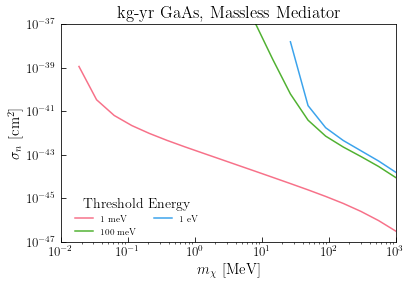

In [3]:
import seaborn as sns

points = 20

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)

import time

for i, mass in enumerate(mdm):
    gaas.update_params(mX = mass, mMed = 0) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = gaas.sigma_multiphonons(1e-3)
    reaches2[i] = gaas.sigma_multiphonons(1e-1)
    reaches3[i] = gaas.sigma_multiphonons(1)

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 3)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$100$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$1$ eV', color=colors[2])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r'kg-yr GaAs, Massless Mediator')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-47,1e-37])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-47,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

plt.savefig(plotdir+"gaas_massless_multiphonon.pdf",bbox_inches='tight')
